In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pypsa

plt.style.use(["bmh", "../../matplotlibrc"])
sns.set_palette("colorblind")

import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100

COUNTRY = "UK"
CASE = "VOLL"

In [88]:
files = {
    "VOLL": f"../../results/20240506-70a/network_solved_LT-country+{COUNTRY}-voll+true.nc",
    "PWL-elastic": f"../../results/20240506-70a/network_solved_LT-country+{COUNTRY}-elastic_pwl+default.nc",
}
n = pypsa.Network(files[CASE])

INFO:pypsa.io:Imported network network_solved_LT-country+UK-voll+true.nc has buses, carriers, generators, links, loads, stores


In [89]:
df = -n.statistics.energy_balance(aggregate_time=False).groupby("carrier").sum().loc["load"]
mean_load = df.mean()

In [90]:
mean_load * 0.6

59.96906894844524

In [91]:
df = pd.DataFrame(df)
df['time_str'] = df.index.strftime('%m-%d %H:00')
df['year'] = df.index.year
pivot = df.pivot(
    index='year', 
    columns='time_str', 
    values='load'
)

new_cols = pd.to_datetime('2024-' + pivot.columns.str[:5], format='%Y-%m-%d').strftime('%b %-d')
pivot.columns = new_cols

In [92]:
# Create discrete levels based on mean_load
discrete_data = pd.DataFrame(index=pivot.index, columns=pivot.columns, dtype=float)

# Assign categories 1-5 (will map to colors)
discrete_data[pivot >= 0.9 * mean_load] = 4
discrete_data[pivot < 0.9 * mean_load] = 3
discrete_data[pivot < 0.8 * mean_load] = 2
discrete_data[pivot < 0.7 * mean_load] = 1

In [93]:
discrete_data.stack().value_counts()

4.0    612597
3.0       778
2.0       257
Name: count, dtype: int64

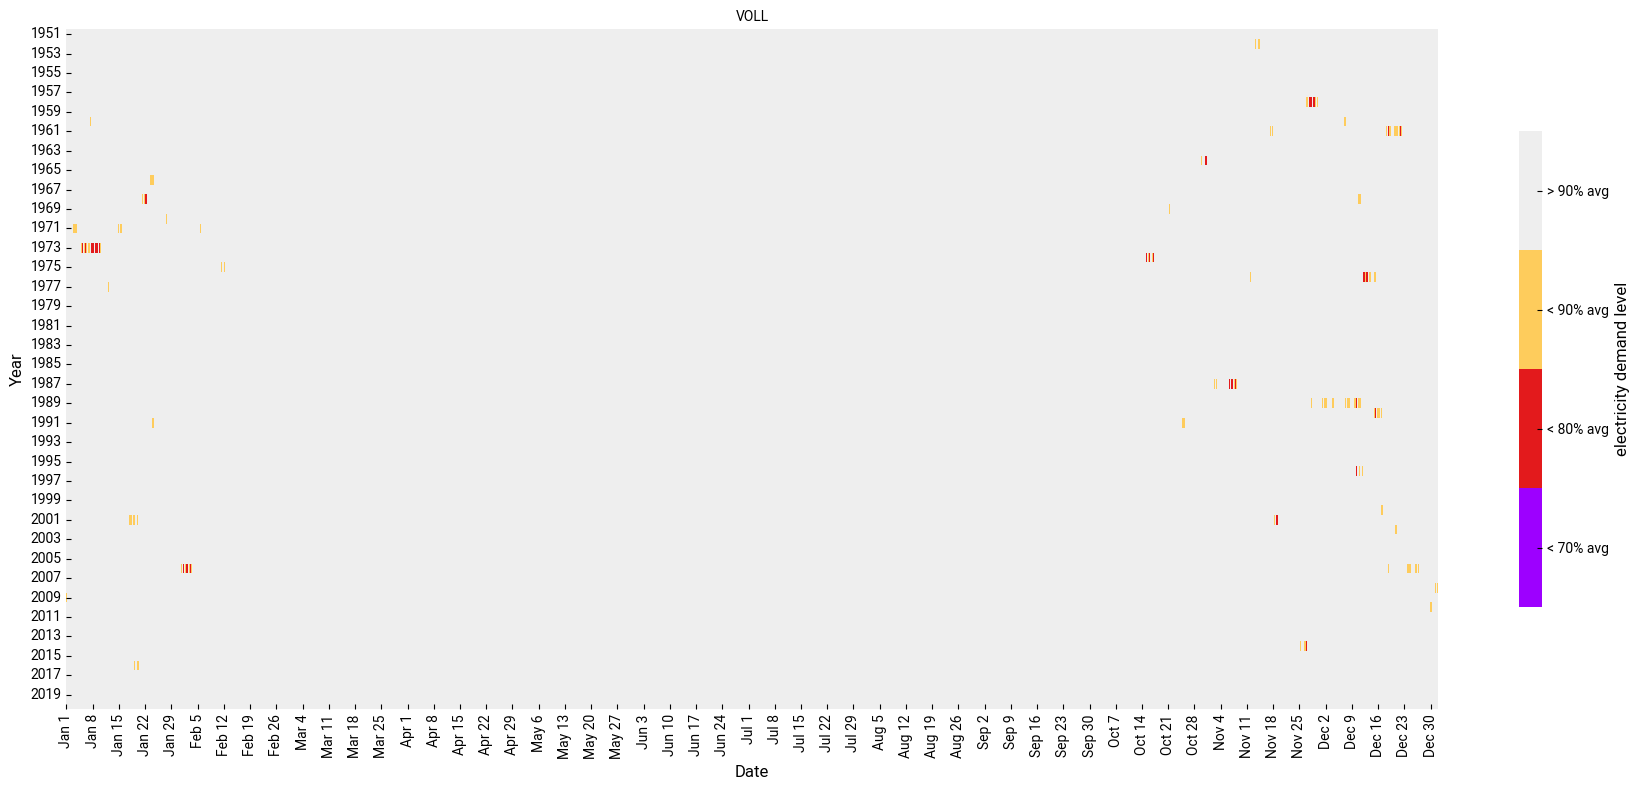

In [94]:
from matplotlib.colors import ListedColormap
colors = ['#9D00FF', '#e31a1c', '#fecc5c', '#eee']
custom_cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(17, 8))
heatmap = sns.heatmap(
    discrete_data,
    cmap=custom_cmap,
    xticklabels=168,
    vmin=0.5,
    vmax=4.5,
    cbar_kws={
        "label": "electricity demand level",
        "ticks": [1, 2, 3, 4],
        "boundaries": [0.5, 1.5, 2.5, 3.5, 4.5],
        "shrink": 0.7,
        "fraction": 0.1,
    },
)

colorbar = heatmap.collections[0].colorbar
colorbar.set_ticklabels([
    '< 70% avg',
    '< 80% avg',
    '< 90% avg',
    '> 90% avg',
])


plt.xlabel('Date')
plt.ylabel('Year')
plt.title(CASE, fontsize="medium")

plt.tight_layout()

plt.savefig(
    f"../../figures/figure-load-heatmaps-{CASE}-{COUNTRY}.png", bbox_inches="tight", dpi=300
)